---
category: 数学
tag: 
  - 数学
  - 概率 
---

# 概率趣题——吃豆子

:::info 按

这篇文章是我在知乎上看到的概率题目后，自己分析、解答的过程。从简单程序模拟入手，到递推式和动态规划，最后求出解析解并证明。希望能给你带来启发。

:::

## 题目

袋子中有白色、黑色两种豆子，且数量相等。每次进行如下操作：

- 从袋子中随机抽取一颗豆子；
- 若为黑色，则直接吃掉；
- 若为白色，则放回重新随机抽取一次，然后不论是什么颜色都直接吃掉。

重复上述操作直到袋中没有豆子。求最后一颗被吃掉的豆子是黑色的概率。

## 题目分析

显然黑色豆子更有可能被吃掉，所以袋中的白色豆子所占比例应该趋向于越来越大。所以最终所求概率应该小于$\frac{1}{2}$。

假设初始有$n$个白色豆子和$n$个黑色豆子。当$n=1$时，我们可以计算出概率：
$$
P(\text{最后一颗是黑色}) = P(\text{第一次抽到白色}) * P(\text{第二次抽到白色}) = \frac 1 4
$$

当$n$变大时，所求概率会更小。因为随着操作次数的增多，黑色豆子应该越来越少，直到达到某个比例，使得黑色豆子被抽出吃掉的概率和白色豆子相等，这样二者的比例才会稳定。随着$n \to \infty$，这个比例应该也逐渐趋近于$0$。那么所求概率也应该逐渐趋近于$0$。

让我们写个程序看看推测是否正确。

## 编程模拟

设最后一个被吃掉的豆子是黑色的概率为$P(n)$，其中$n$是初始时白色豆子的数量和黑色豆子的数量。

首先让我们验证$P(1) = \frac 1 4$。

In [1]:
import random
from typing import Tuple

# 用 Tuple[int, int] 描述容器状态（白色豆子数，黑色豆子数）
ContainerState = Tuple[int, int]

# 操作一次（指按题目操作直到吃掉一颗豆子），并返回容器状态
def operate_once(state: ContainerState) -> ContainerState:
    selection = 0 if random.randint(0, state[0] + state[1] - 1) < state[0] else 1
    if selection == 0:
        # 抽到白色豆子，放回并重新抽取
        selection = 0 if random.randint(0, state[0] + state[1] - 1) < state[0] else 1
    if selection == 0:
        return state[0] - 1, state[1]
    else:
        return state[0], state[1] - 1

# 模拟一遍完整的操作过程，并返回最后一个吃掉的豆子的颜色（0 为白色，1 为黑色）
def simulate(n: int) -> int:
    state = n, n
    while state[0] and state[1]:
        state = operate_once(state)
    return 0 if state[0] else 1

# 模拟多次，并计算 P(n)；其中 T 为总模拟次数
def simulate_and_calc_prob(n: int, T: int = 100000) -> float:
    num_cases_last_is_black = 0
    num_cases_total = T
    for _ in range(num_cases_total):
        result = simulate(n)
        if result == 1:
            num_cases_last_is_black += 1
    return float(num_cases_last_is_black) / float(num_cases_total)

print("P(1) =", simulate_and_calc_prob(1))

P(1) = 0.25098


## 更多的豆子

结果和我们预想的一致。让我们尝试一下更大的$n$。

In [2]:
for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), simulate_and_calc_prob(n))

P(1) = 0.25073
P(2) = 0.16579
P(3) = 0.12502
P(4) = 0.09817
P(5) = 0.08408
P(10) = 0.04548
P(100) = 0.005


## 更快的程序？

好吧，结果确实随着$n$的增大而逐渐接近零了，这符合我们的预期。但是这个程序太慢了，我们来尝试加速一下这个程序。

注意到每次抽取豆子时，抽到不同豆子的概率与剩余两种豆子的数量有关。假设现在有$x$个白色豆子和$y$个黑色豆子，下一个吃掉的豆子的颜色为白色和黑色的概率分别是：
$$
\begin{aligned}
P(\text{吃到白色豆子}) &= P(\text{第一次抽出白色}) \cdot P(\text{第二次抽出白色}) \\
&= \frac{x}{x + y} \times \frac{x}{x + y} \\
&= \frac{x^2}{(x + y)^2} \\
P(\text{吃到黑色豆子}) &= P(\text{第一次抽到黑色}) + P(\text{第一次抽到白色}) \cdot P(\text{第二次抽到黑色}) \\
&= \frac{y}{x + y} + \frac{x}{x + y} \times \frac{y}{x + y} \\
&= \frac{2 x y + y^2}{(x + y)^2}
\end{aligned}
$$

让我们基于这些公式重写一下程序。

In [3]:
# 操作一次（指按题目操作直到吃掉一颗豆子），并返回容器状态
def operate_once_faster(state: ContainerState) -> ContainerState:
    prob_white = float(state[0]) * float(state[0]) / (float(state[0] + state[1]) * float(state[0] + state[1]))
    selection = 0 if random.random() < prob_white else 1
    if selection == 0:
        return state[0] - 1, state[1]
    else:
        return state[0], state[1] - 1
    
# 模拟一遍完整的操作过程，并返回最后一个吃掉的豆子的颜色（0 为白色，1 为黑色）
def simulate_faster(n: int) -> int:
    state = n, n
    while state[0] and state[1]:
        state = operate_once_faster(state)
    return 0 if state[0] else 1

# 模拟多次，并计算 P(n)；其中 T 为总模拟次数
def simulate_and_calc_prob_faster(n: int, T: int = 100000) -> float:
    num_cases_last_is_black = 0
    num_cases_total = T
    for _ in range(num_cases_total):
        result = simulate_faster(n)
        if result == 1:
            num_cases_last_is_black += 1
    return float(num_cases_last_is_black) / float(num_cases_total)

for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), simulate_and_calc_prob_faster(n))

P(1) = 0.25076
P(2) = 0.1669
P(3) = 0.1241
P(4) = 0.10211
P(5) = 0.08278
P(10) = 0.04681
P(100) = 0.00507


## 不再模拟

当然刚才这样并不会让程序变快，因为总的模拟次数并没有变少。（虽然我们调用`random()`函数的次数确实变少了。）但观察这些公式，我们可以发现一个不用多次模拟就能求得概率的方法！

设当前状态为$(x, y)$，即有$x$颗白色豆子和$y$颗黑色豆子。我们用$P(x, y)$表示$P(\text{最后一颗是黑色}|\text{状态为}(x,y))$。那么$P(n, n)$就是题目所求概率。注意：我们之所以可以这样做，是因为在状态为$(x, y)$的情况下，最后一颗是黑色的概率与之前的豆子数、吃豆顺序都已经无关了，即我们常说的“无后效性”。

利用递推的方法，我们可以建立$P(x, y)$和$P(x - 1, y)$、$P(x, y - 1)$之间的关系：
$$
\begin{aligned}
P(x, y) &= P(\text{吃到白色豆子}) \cdot P(x - 1, y) + P(\text{吃到黑色豆子}) \cdot P(x, y - 1)\\
&=\frac{x^2}{(x + y)^2} \cdot P(x - 1, y) + \frac{2 x y + y^2}{(x + y)^2} \cdot P(x, y - 1)
\end{aligned}
$$

我们还知道初始条件：
$$
\begin{aligned}
P(0, y) &= 1\\
P(x, 0) &= 0
\end{aligned}
$$

那么我们可以用动态规划的方法求出$P(n, n)$的值。

In [4]:
from typing import List

# 用动态规划计算 P(x, y)
def calc_prob_by_dp(n: int) -> float:
    # p[x] = P(x, y)，其中 y 随着迭代的进行会不断变化。
    p: List[float] = [0.0] * (n + 1)
    # last_p[x] = P(x, y - 1)
    last_p: List[float] = [0.0] * (n + 1)
    
    for y in range(1, n + 1):
        p[0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[x] = prob_white * p[x - 1] + (1.0 - prob_white) * last_p[x]
        p, last_p = last_p, p
    
    return last_p[n]

for n in [1, 2, 3, 4, 5, 10, 100]:
    print("P({}) =".format(n), calc_prob_by_dp(n))

P(1) = 0.25
P(2) = 0.16666666666666666
P(3) = 0.125
P(4) = 0.09999999999999999
P(5) = 0.08333333333333333
P(10) = 0.04545454545454545
P(100) = 0.004950495049504951


## 画图

虽然得到了数值解，但是我们感觉到，这个题目应该是有解析解的，解析解可以通过递推式求出。但是我这么菜，显然是看不出来如何求解析解的，所以我们从数值解找找规律。

我们来画一下$P(n, n)$随$n$变化的图像。

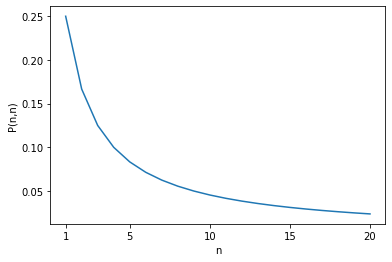

In [6]:
# 用动态规划计算 P(x, y)
def calc_prob_by_dp_all(n: int) -> List[float]:
    # p[x] = P(x, y)，其中 y 随着迭代的进行会不断变化。
    p: List[float] = [0.0] * (n + 1)
    # last_p[x] = P(x, y - 1)
    last_p: List[float] = [0.0] * (n + 1)
    # p_all[n - 1] = P(n, n)
    p_all: List[float] = [0.0] * n
    
    for y in range(1, n + 1):
        p[0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[x] = prob_white * p[x - 1] + (1.0 - prob_white) * last_p[x]
        p_all[y - 1] = p[y]
        p, last_p = last_p, p
    
    return p_all

from matplotlib import pyplot as plt

N = 20
ps = calc_prob_by_dp_all(N)
ns = list(range(1, N + 1))
plt.plot(ns, ps)
plt.xlabel('n')
plt.xticks([1, 5, 10, 15, 20])
plt.ylabel('P(n,n)')
plt.show()

## 结果分析

图像看起来是符合预期的。而且所求概率随着$n$的增大大约是反比例衰减的。

我们注意到：
$$
\begin{aligned}
P(1) &= \frac 1 4 &\qquad
P(2) &\approx \frac 1 6\\
P(3) &\approx \frac 1 8 &\qquad
P(4) &\approx \frac 1 {10}\\
P(5) &\approx \frac 1 {12} &\qquad
P(10) &\approx \frac 1 {22}\\
P(100) &\approx \frac 1 {202} &\qquad&
\end{aligned}
$$

嗯……看起来:
$$
P(n, n) = \frac{1}{2n+2}
$$

可是只猜到了$P(n, n)$的表达式，是无法完成证明的。要想通过递推式证明这个表达式，需要先得到任意的$P(x, y)$的表达式。我们最好还是画一下图、列一下数据看看。

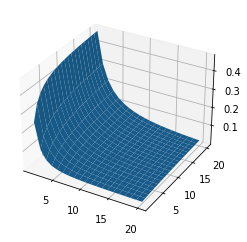

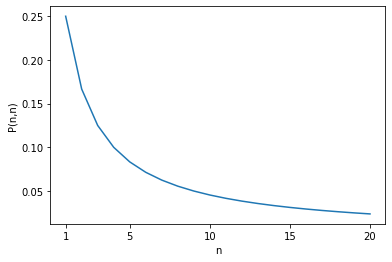

In [8]:
# 用动态规划计算 P(x, y)
def calc_prob_by_dp_all_xy(n: int) -> List[List[float]]:
    # p[y][x] = P(x, y)
    p: List[List[float]] = [[0.0] * (n + 1) for _ in range(n + 1)]
    
    for y in range(1, n + 1):
        p[y][0] = 1.0
        for x in range(1, n + 1):
            prob_white = float(x) * float(x) / (float(x + y) * float(x + y))
            p[y][x] = prob_white * p[y][x - 1] + (1.0 - prob_white) * p[y - 1][x]
    
    return p

import numpy as np

N = 20
p = calc_prob_by_dp_all_xy(N)
x, y = np.meshgrid(np.arange(1, N + 1), np.arange(1, N + 1))
axes = plt.axes(projection='3d')
axes.plot_surface(x, y, np.array([p[y + 1][1:] for y in range(N)]))
plt.show()
plt.figure()
ps = [p[n][n] for n in ns]
plt.plot(ns, ps)
plt.xlabel('n')
plt.xticks([1, 5, 10, 15, 20])
plt.ylabel('P(n,n)')
plt.show()

In [10]:
import pandas as pd
pd.DataFrame(np.array(p)[:-1,:-1])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.250000,0.111111,0.062500,0.040000,0.027778,0.020408,0.015625,0.012346,0.010000,0.008264,0.006944,0.005917,0.005102,0.004444,0.003906,0.003460,0.003086,0.002770,0.002500
2,1.0,0.333333,0.166667,0.100000,0.066667,0.047619,0.035714,0.027778,0.022222,0.018182,0.015152,0.012821,0.010989,0.009524,0.008333,0.007353,0.006536,0.005848,0.005263,0.004762
3,1.0,0.375000,0.200000,0.125000,0.085714,0.062500,0.047619,0.037500,0.030303,0.025000,0.020979,0.017857,0.015385,0.013393,0.011765,0.010417,0.009288,0.008333,0.007519,0.006818
4,1.0,0.400000,0.222222,0.142857,0.100000,0.074074,0.057143,0.045455,0.037037,0.030769,0.025974,0.022222,0.019231,0.016807,0.014815,0.013158,0.011765,0.010582,0.009569,0.008696
5,1.0,0.416667,0.238095,0.156250,0.111111,0.083333,0.064935,0.052083,0.042735,0.035714,0.030303,0.026042,0.022624,0.019841,0.017544,0.015625,0.014006,0.012626,0.011442,0.010417
6,1.0,0.428571,0.250000,0.166667,0.120000,0.090909,0.071429,0.057692,0.047619,0.040000,0.034091,0.029412,0.025641,0.022556,0.020000,0.017857,0.016043,0.014493,0.013158,0.012000
7,1.0,0.437500,0.259259,0.175000,0.127273,0.097222,0.076923,0.062500,0.051852,0.043750,0.037433,0.032407,0.028340,0.025000,0.022222,0.019886,0.017903,0.016204,0.014737,0.013462
8,1.0,0.444444,0.266667,0.181818,0.133333,0.102564,0.081633,0.066667,0.055556,0.047059,0.040404,0.035088,0.030769,0.027211,0.024242,0.021739,0.019608,0.017778,0.016194,0.014815
9,1.0,0.450000,0.272727,0.187500,0.138462,0.107143,0.085714,0.070312,0.058824,0.050000,0.043062,0.037500,0.032967,0.029221,0.026087,0.023438,0.021176,0.019231,0.017544,0.016071


## 结果再分析

嗯……看起来：
$$
\begin{aligned}
P(x,1)&=\frac{1}{(x+1)^2}\\
P(x,2)&=\frac{2}{(x+1)(x+2)}\\
P(x,3)&=\frac{3}{(x+1)(x+3)}\\
...&
\end{aligned}
$$
也许我们有：
$$
P(x,y)=\frac{y}{(x+1)(x+y)}
$$

这个猜得对不对呢？我们验证一下。首先它确实满足我们之前的猜测$P(n,n)=\frac{1}{2n+2}$。

接下来我们验证它完全正确。首先关于边界条件，有：
$$
\begin{aligned}
P(x, 0) &= \frac{0}{x(x+1)} = 0\\
P(0, y) &= \frac{y}{y} = 1
\end{aligned}
$$

结果不错。然后是递推式：
$$
\begin{aligned}
P(x, y) &= \frac{x^2}{(x + y)^2} \cdot P(x - 1, y) + \frac{2 x y + y^2}{(x + y)^2} \cdot P(x, y - 1) \\
&= \frac{x^2}{(x + y)^2} \cdot \frac{y}{x(x+y-1)} + \frac{2 x y + y^2}{(x + y)^2} \cdot \frac{y-1}{(x+1)(x+y-1)} \\
&= \frac{xy(x+1)}{(x + y)^2(x+1)(x+y-1)} + \frac{(2 x y + y^2)(y-1)}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{x^2y+xy+2xy^2+y^3-2xy-y^2}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y(x^2+x+2xy+y^2-2x-y)}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y((x+y)^2-(x+y))}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y((x+y)(x+y-1))}{(x + y)^2(x+1)(x+y-1)} \\
&= \frac{y}{(x+1)(x+y)}
\end{aligned}
$$

## OHHHHHHH

太棒了，所以初始有$x$颗白色豆子和$y$颗黑色豆子时，最后一颗是黑色的概率是：
$$
P(x,y)=\frac{y}{(x+1)(x+y)}
$$
对于题目所说的初始时黑色豆子和白色豆子相同（均为$n$）的条件下，最后一颗是黑色的概率是：
$$
P(n, n) = \frac{1}{2n+2}
$$